In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
#import os
#os.remove("/kaggle/working/models")
#import shutil
#shutil.rmtree("/kaggle/working/models")

In [68]:
import os
#PATH ALLOCATION
data_dir=os.path.join('/kaggle/input/vision-transformer/data')
classes=os.listdir(data_dir)
classes = sorted(classes)
classes

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Beetle',
 'Black Hairy',
 'Catterpillar',
 'Corn Earworms',
 'Flea beetle',
 'Grasshopper',
 'Grub',
 'Leafhopper',
 'Red Mite']

In [69]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.nn as nn
import torch.optim as optim
import torch

In [70]:
class CustomDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.images, self.labels = self.load_data(folder)

    def load_data(self, folder):
        images = []
        labels = []
        class_names = sorted(os.listdir(folder))
        for class_index, class_name in enumerate(class_names):
            class_path = os.path.join(folder, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224,224))  # Resize images to fit ViT input size
                images.append(image)
                labels.append(class_index)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [71]:
# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # ImageNet normalization
])
# Define your data folder
data_folder = '/kaggle/input/vision-transformer/data'

# Create custom dataset instances
dataset = CustomDataset(data_folder, transform=transform)

# Split data into train and test sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset.labels)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


torch.Size([32, 3, 224, 224])


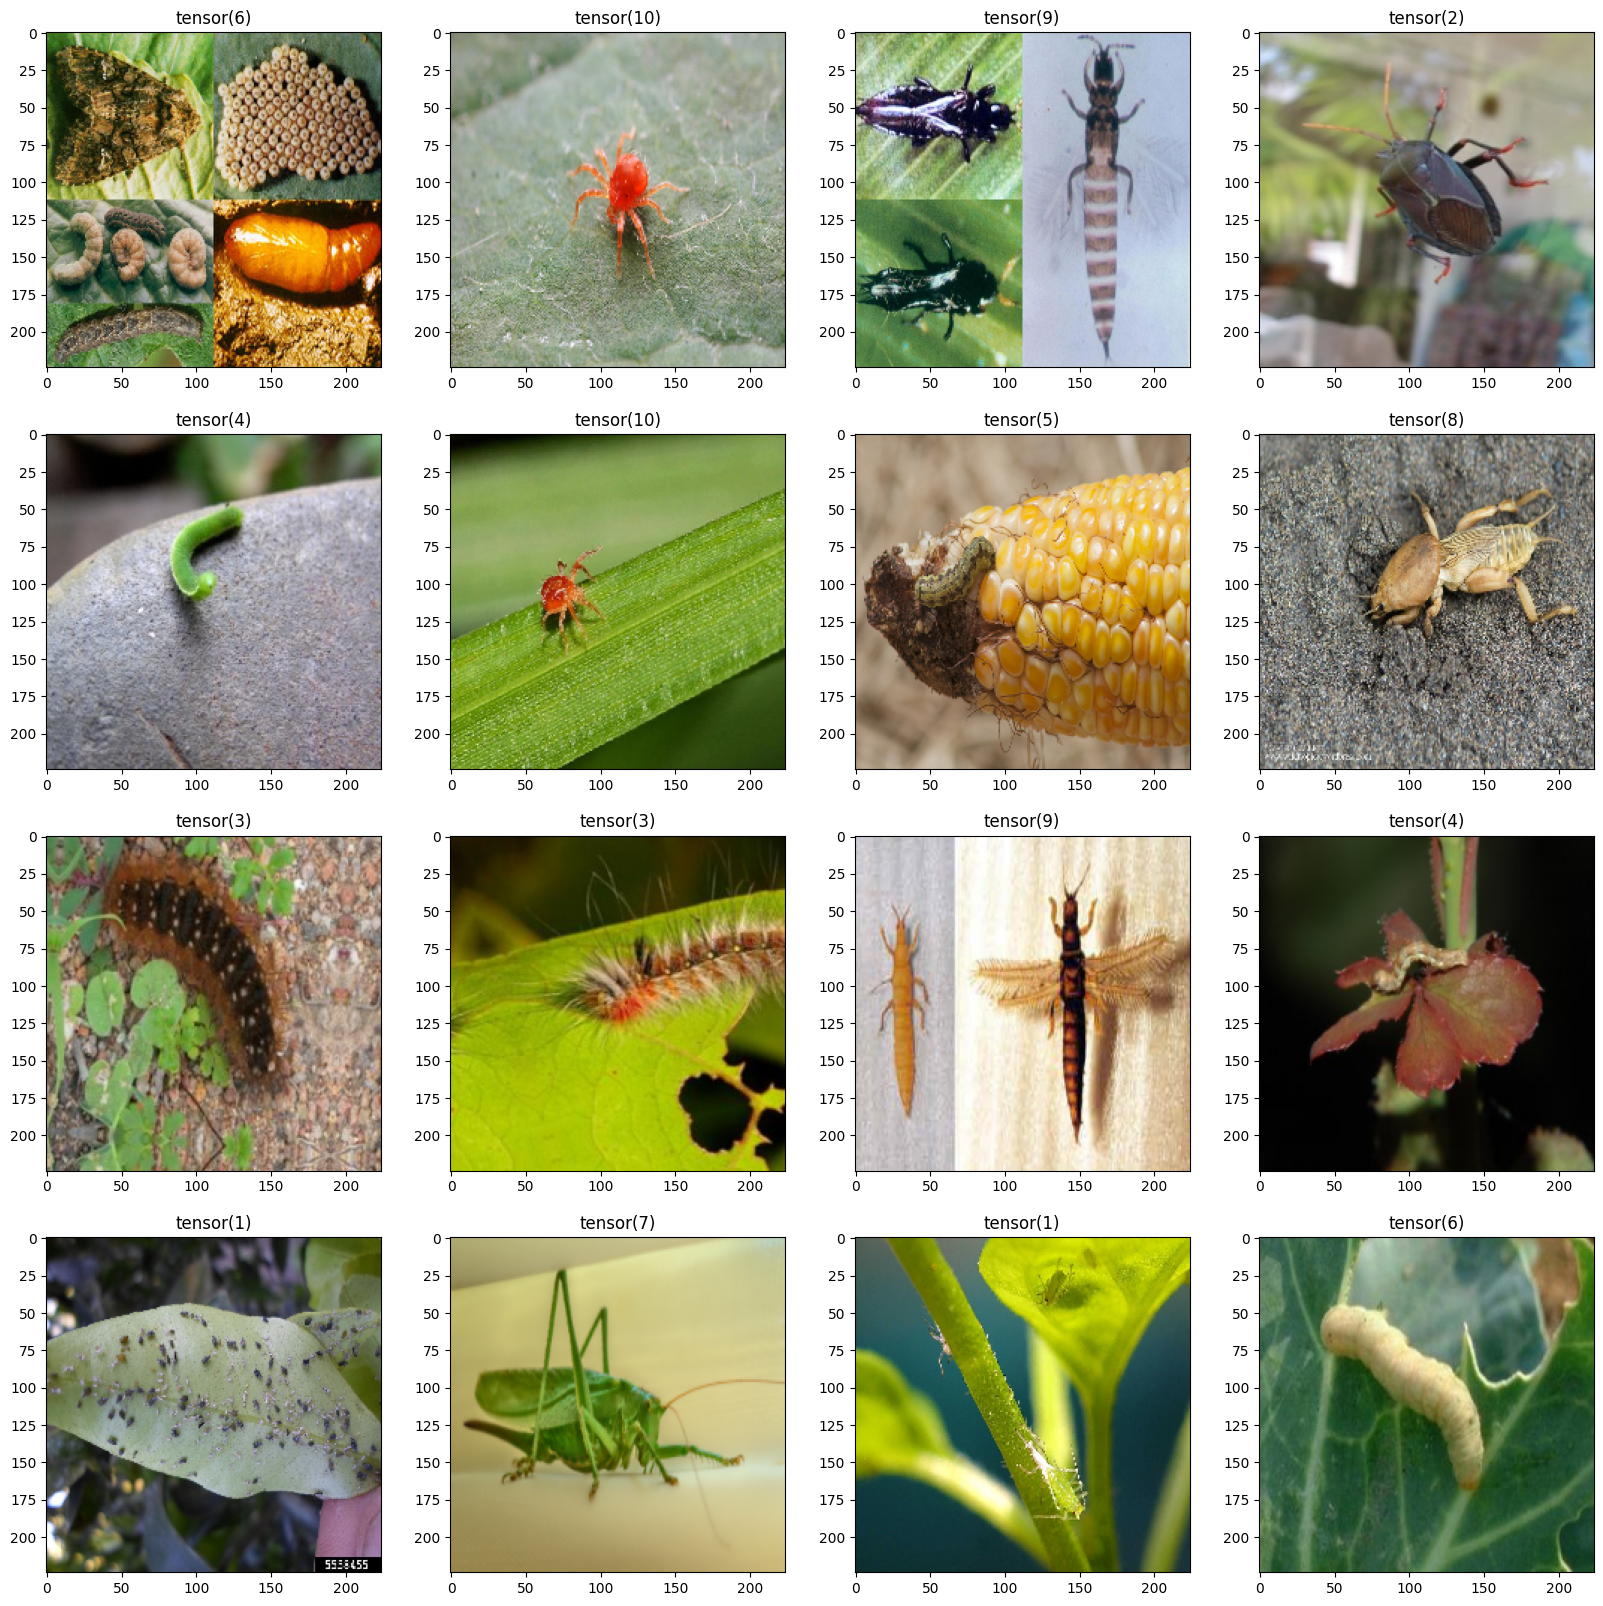

In [72]:
import matplotlib.pyplot as plt
train_images, train_labels = next(iter(train_loader))  # Example using the train_loader

print(train_images.shape)

fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(20,20))
ax=ax.flatten()
for i, j in enumerate(train_images[:16]):
    if isinstance(j, torch.Tensor):  # If PyTorch tensor
        j = j.permute(1, 2, 0)  # Permute to (height, width, channels)
        ax[i].imshow(j)    #already in minimal scaled range
        ax[i].title.set_text(train_labels[i])
            

In [ ]:
'''# Load pre-trained ViT model
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_name)

# Modify the classification head
num_classes = 11  # Example: if you have 11 classes in your dataset
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

# Fine-tune the pre-trained model on your dataset
learning_rate = 1e-4
weight_decay = 1e-5  # Hyperparameter: L2 regularization weight decay
dropout_rate = 0.1  # Hyperparameter: Dropout probability

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay )
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)'''



"# Load pre-trained ViT model\nmodel_name = 'google/vit-base-patch16-224-in21k'\nmodel = ViTForImageClassification.from_pretrained(model_name)\n\n# Modify the classification head\nnum_classes = 11  # Example: if you have 11 classes in your dataset\nmodel.classifier = nn.Linear(model.config.hidden_size, num_classes)\n\n# Fine-tune the pre-trained model on your dataset\nlearning_rate = 1e-4\nweight_decay = 1e-5  # Hyperparameter: L2 regularization weight decay\ndropout_rate = 0.1  # Hyperparameter: Dropout probability\n\noptimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay )\ncriterion = nn.CrossEntropyLoss()\n\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nmodel.to(device)"

In [74]:

# Load pre-trained ViT model
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_name)

# Modify the classification head
num_classes = 11  # Example: if you have 11 classes in your dataset
model.classifier = nn.Sequential(
    nn.Linear(model.config.hidden_size, model.config.hidden_size),
    nn.Dropout(p=0.1),  # Dropout after the first linear layer (adjustable)
    nn.Linear(model.config.hidden_size, num_classes)
)

# Fine-tune the pre-trained model on your dataset
learning_rate = 0.001 #1e-5   
weight_decay =  1e-4 #1e-5  # Hyperparameter: L2 regularization weight decay

# Freeze pre-trained layers (except classification head)
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters by default

# Unfreeze the classification head for training
for param in model.classifier.parameters():
    param.requires_grad = True  # Allow gradients for the classification head


optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [75]:
model.config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.38.1"
}

In [76]:
import copy
training_losses = []
training_accuracies = []

epochs = 10
patience = 7  # Number of epochs to wait for improvement before stopping

# Initialize best model state to save the best performing model
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)['logits']
        _, predicted = torch.max(outputs.data, 1)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item() * inputs.size(0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / total

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}')

    training_losses.append(epoch_loss)
    training_accuracies.append(accuracy)

    # Early stopping logic
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0  # Reset counter for early stopping
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping triggered after {patience} epochs with no improvement')
            break

# Load the best model weights
model.load_state_dict(best_model_wts)

print('Finished fine-tuning.')


Epoch [1/10], Loss: 0.9111, Accuracy: 0.82
Epoch [2/10], Loss: 0.1966, Accuracy: 0.96
Epoch [3/10], Loss: 0.0908, Accuracy: 0.98
Epoch [4/10], Loss: 0.0503, Accuracy: 0.99
Epoch [5/10], Loss: 0.0262, Accuracy: 1.00
Epoch [6/10], Loss: 0.0171, Accuracy: 1.00
Epoch [7/10], Loss: 0.0119, Accuracy: 1.00
Epoch [8/10], Loss: 0.0089, Accuracy: 1.00
Epoch [9/10], Loss: 0.0068, Accuracy: 1.00
Epoch [10/10], Loss: 0.0053, Accuracy: 1.00
Finished fine-tuning.


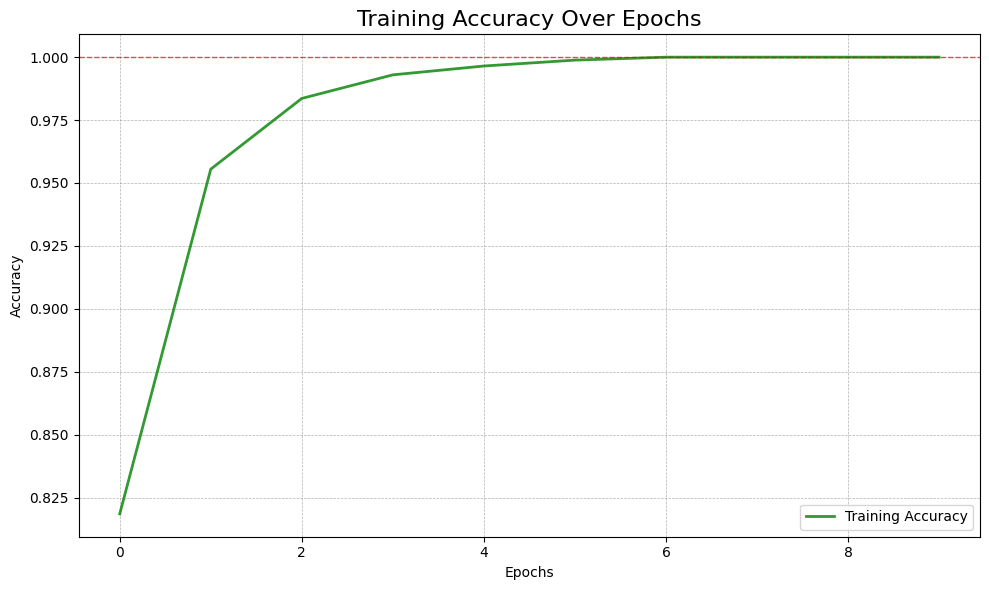

In [77]:
import matplotlib.pyplot as plt

# Assuming you have your training accuracies stored in a list named 'training_accuracies'

# 1. Increase the figure size for a clearer view
plt.figure(figsize=(10, 6))  # Adjust width and height as desired

# 2. Enhance the plot line
plt.plot(training_accuracies, color="green", linewidth=2, alpha=0.8, label="Training Accuracy")  # Thicker line with some transparency

# 3. Add informative labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs", fontsize=16)  # Larger title font

# 4. Customize the grid and background
plt.grid(True, linestyle="--", linewidth=0.5, color="gray", which="both", alpha=0.6)  # Finer grid with some transparency
plt.axhline(y=1, color="red", linestyle="--", linewidth=1, alpha=0.7)  # Reference line for perfect accuracy

# 5. Add a legend for clarity (if applicable)
plt.legend()

# 6. Enhance the x-axis ticks (optional)
#plt.xticks(range(len(training_accuracies)), range(1, len(training_accuracies) + 1))  # Show epoch numbers on x-axis

# 7. Refine the plot margins (optional)
plt.tight_layout()

# 8. Show the plot
plt.show()


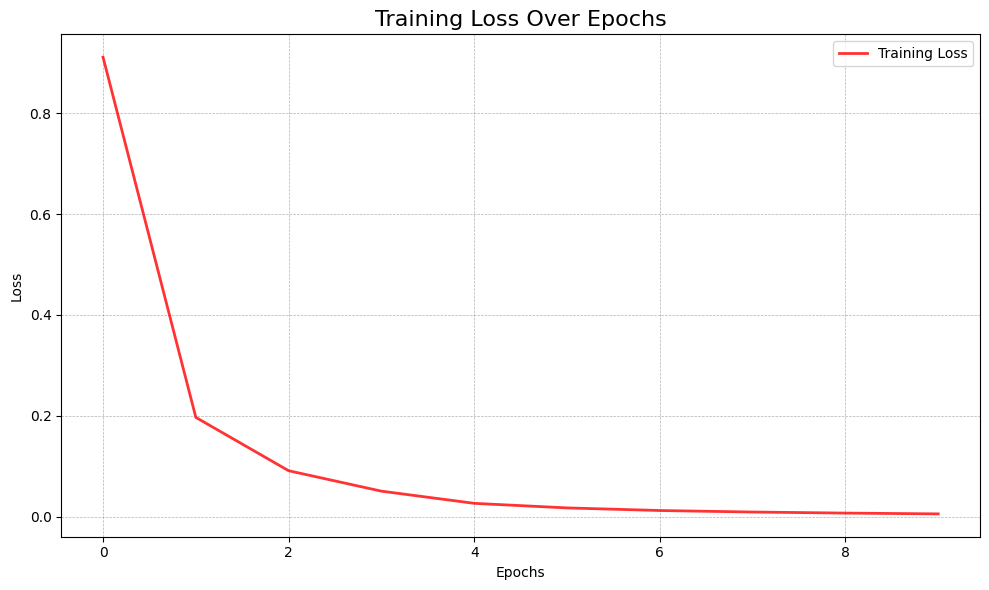

In [78]:
import matplotlib.pyplot as plt

# Assuming you have your training loss data in a list named 'vis['loss']'

# 1. Increase the figure size for a clearer view
plt.figure(figsize=(10, 6))  # Adjust width and height as desired

# 2. Enhance the loss curve
plt.plot(training_losses, color="red", linewidth=2, alpha=0.8, label="Training Loss")  # Thicker line with some transparency

# 3. Add informative labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs", fontsize=16)  # Larger title font

# 4. Customize the grid and background
plt.grid(True, linestyle="--", linewidth=0.5, color="gray", which="both", alpha=0.6)  # Finer grid with some transparency

# 5. Optional: Include validation loss if available (uncomment the line below)
# plt.plot(vis['val_loss'], color="blue", linewidth=1, alpha=0.7, label="Validation Loss")  # Add validation loss curve

# 6. Add a legend for clarity
plt.legend()

# 7. Refine the plot margins (optional)
plt.tight_layout()

# 8. Show the plot
plt.show()


In [81]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Test Accuracy: 0.9065
Precision: 0.9076
Recall: 0.9065
F1 Score: 0.9042


In [82]:
import torch

# Function to make predictions
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Use the function to make predictions on test data
test_predictions = predict(model, test_loader, device)
print("Test Predictions:", test_predictions)


Test Predictions: [9, 7, 2, 4, 9, 5, 2, 1, 10, 5, 4, 4, 1, 3, 2, 6, 3, 0, 4, 1, 5, 4, 8, 4, 10, 3, 9, 0, 7, 9, 10, 8, 7, 6, 8, 0, 5, 5, 6, 10, 0, 0, 0, 9, 5, 5, 6, 0, 9, 7, 8, 7, 10, 1, 9, 1, 1, 10, 5, 1, 6, 0, 3, 7, 6, 0, 7, 5, 1, 7, 7, 9, 0, 5, 3, 9, 8, 0, 5, 10, 10, 3, 3, 10, 8, 10, 10, 7, 7, 7, 9, 7, 9, 0, 6, 1, 3, 7, 10, 3, 4, 9, 6, 5, 7, 0, 3, 1, 4, 7, 4, 2, 3, 1, 9, 4, 8, 10, 5, 5, 7, 6, 8, 8, 4, 8, 8, 7, 6, 9, 2, 9, 7, 4, 10, 2, 2, 7, 2, 6, 2, 9, 0, 10, 3, 1, 10, 8, 1, 1, 9, 10, 10, 4, 6, 7, 5, 6, 10, 8, 4, 2, 5, 2, 5, 5, 10, 9, 3, 3, 9, 8, 0, 1, 6, 0, 4, 5, 1, 9, 2, 4, 10, 6, 0, 7, 1, 2, 7, 2, 8, 9, 8, 9, 0, 8, 3, 1, 4, 6, 7, 3, 6, 4, 0, 5, 6, 3, 3, 2, 8, 3, 2, 6]


In [86]:
# After your training loop
torch.save(model, 'my_model.pt')  # Replace 'my_model.pt' with your desired filename


In [87]:
# Define your data transformation (same as before)
transform = transforms.Compose([
  transforms.ToTensor(),
])

# Load your single image (replace with your image path)
image_path = '/kaggle/input/vision-transformer/data/Africanized Honey Bees (Killer Bees)/Image_100.jpg'
image = cv2.imread(image_path)

# Preprocess the image (resize and convert to tensor)
image = cv2.resize(image, (224, 224))  # Assuming your model expects 224x224 input
image = transform(image).unsqueeze(0)  # Add a batch dimension (B, C, H, W)

# Load the saved model
model = torch.load('my_model.pt')  # Replace 'my_model.pt' with your filename

# Move the model to the device (if using GPU)
model.to(device)

# Function to make a single prediction
def predict_single(model, image, device):
  model.eval()
  with torch.no_grad():
    image = image.to(device)
    outputs = model(image).logits
    _, prediction = torch.max(outputs, 1)
  return prediction.cpu().numpy()

# Make prediction on the single image
prediction = predict_single(model, image, device)

# Print the prediction (assuming you have class names)
class_names = ['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Beetle',
 'Black Hairy',
 'Catterpillar',
 'Corn Earworms',
 'Flea beetle',
 'Grasshopper',
 'Grub',
 'Leafhopper',
 'Red Mite']
# Replace with your actual class names
print(f"Image Prediction: {class_names[prediction[0]]}")  # Access the single prediction element


Image Prediction: Africanized Honey Bees (Killer Bees)
